# Plasmons in the Kretschmann-Raether Configuration

This project is a work in progress and is being completed as an assignment related to the Labratory Practices class in the Masters's Degree in Photonics (MDP) program at the University of Eastern Finland. The goal is to investigate surface plasmon propagation on metalic surface. In particular it is to first theoretically characterize the case of plasmons propagating on a gold film in the Kretschmann-Raether across the visible range. After this has been completed the theoretical results will be compared with experiments results. To start it is necessary to import the packages that will be used. I have included a few more imports than I normaly would in an effort to increase readability.

In [1]:
import pandas as pd
import numpy as np
from numpy import sin, pi as π #lib.scimath.sqrt as sqrt
from numpy.lib.scimath import sqrt
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

Declare the starting parameters as given by Heikki Rekola. The Basis for these parameters was that here we are interested in the optical wavlength range, and that outside of the range of 40-60$^\circ$ there will not be any interesting results. The thickness of the metal film at the base of the prism is given as 50 nm. The vaccum permeability is given by Hecht Optics as 8.8541878128$\cdot$10$^{-12}$ Farads/m (there is an unfortunate conflict between the notation used by Raether, and the standard notation for vaccum permeability $\epsilon_0$, Raethers notation will be used throughout). 

In [2]:
#%% Givens
res = 101 #Number of points
λ_min = .380 #Approximate lower threshold for visible light
λ_max = .800 #Approximate lower threshold for visible light
λ = np.linspace(λ_min, λ_max, res) #Optical range in micrometers range from advisor
#λ = .550 #placeholder value for testing
θ_min = 40 #lower limit in degrees
θ_max = 60 #Upper limit in degrees 
θ = np.linspace(θ_min, θ_max, res) #Sugested range from advisor
#θ = 50 #placeholder value for testing
d = 0.05E-6 #Film is given as 50 nm thick
ε0 = 8.8541878128E-18 #F/µm (farads per micrometer)
Rp = np.empty(res)
#c = 299792458 #Meters per second

While for some materials it is possible to consider the refractive index ($n$) as a constant, in reality it varries with wavelength ($\lambda$). For the sake of consistency, all three materials in the setup will be treated as similar as possible. First, the refractive index is retreived from https://refractiveindex.info/ . Next the datframes are converted to numpy arrays, and then interpolated.

In [3]:
n_Au = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/main/Au/Johnson.yml')
n_BK7 = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/glass/schott/N-BK7.yml')
n_Air = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/other/mixed%20gases/air/Ciddor.yml')

n_Au = (n_Au.apply(pd.to_numeric, errors='coerce')).to_numpy()[:49,:49]
n_BK7 = (n_BK7.apply(pd.to_numeric, errors='coerce')).to_numpy()[:101,:101]
n_Air = (n_Air.apply(pd.to_numeric, errors='coerce')).to_numpy()

n_Au = interpolate.interp1d(n_Au[:,0], n_Au[:,1])
n_BK7 = interpolate.interp1d(n_BK7[:,0], n_BK7[:,1])
n_Air = interpolate.interp1d(n_Air[:,0], n_Air[:,1])

If the refractive index is plotted across the optical spectrum, it becomes obvious why Au needed to be treated as a function rather than a constant.

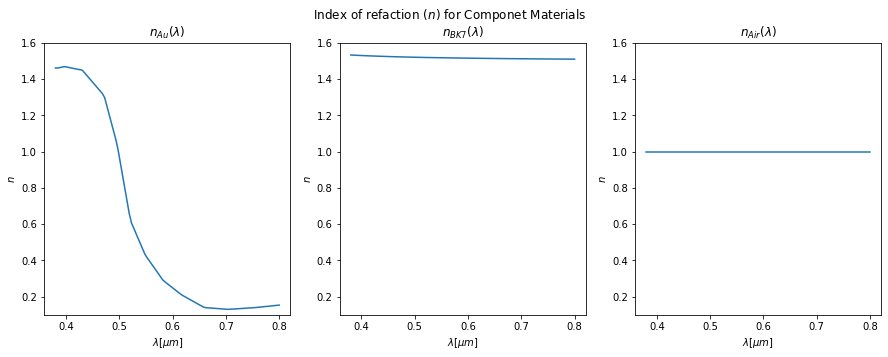

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [15, 5])
plt.suptitle('Index of refaction ($n$) for Componet Materials')
axs[0].set(title='$n_{Au} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[0].plot(λ,n_Au(λ))

axs[1].set(title='$n_{BK7} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[1].plot(λ,n_BK7(λ))

axs[2].set(title='$n_{Air} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[2].plot(λ,n_Air(λ))

The next step in being able to use equation 2.17 is to be able to solve for the permeabilty for the materials in the system, and wave number in the medium. For finding the permeability, the relative permeabilty is multiplied by the relative permeability. Hecht Optics gives the condition that when the material is non-magnetic Maxwell's Realtion may be applied.

In [5]:
#ε_0 = ε0*n_BK7(λ)**2
#ε_1 = ε0*n_Au(λ)**2
#ε_2 = ε0*n_Air(λ)**2
ε_0 = n_BK7(λ)**2
ε_1 = n_Au(λ)**2
ε_2 = n_Air(λ)**2

Of course the wave vector will also be dependent on the refractive index and therefore the value must be found for each wavelength.

In [6]:
k_x = np.empty([res,res])
for n in range(res):
    for m in range(res):
        k_x[n, m] = (2*π*(n_BK7(λ[n])/λ[n])*sin(np.deg2rad(θ[m])))**2

In [7]:
k_z0 = sqrt(ε_0*(2*π/λ)**2 - k_x)
k_z1 = sqrt(ε_1*(2*π/λ)**2 - k_x)
k_z2 = sqrt(ε_2*(2*π/λ)**2 - k_x)

Bringing this all together in equation 2.17 yields

In [8]:
rp_01 = (k_z0/ε_0 - k_z1/ε_1)/(k_z0/ε_0 + k_z1/ε_1)
rp_12 = (k_z1/ε_1 - k_z2/ε_2)/(k_z1/ε_1 + k_z2/ε_2)

With the help of equation 2.16, everything in equation 2.17 is now known, and $R_p(\lambda)$ may now be solved.

In [9]:
Rp = np.abs(rp_01+rp_12*np.exp(2*1j*k_z1*d)/(1+rp_01*rp_12*np.exp(2*1j*k_z1*d)))**2 

Now it is possible to plot $R_p(\theta)$ for a range of wavelengths.

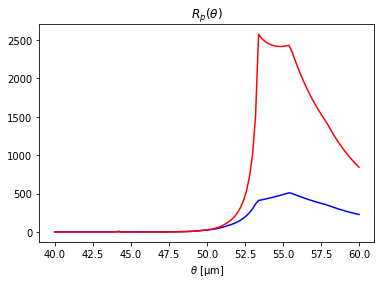

In [10]:
plt.plot(θ, Rp[0,:], color = 'b')
plt.plot(θ, Rp[res-1,:], color = 'r')
plt.title('$R_p(\\theta)$')
plt.xlabel('$\\theta$ [μm]')
plt.show()